#### Team members:
* ...
* ...
* ...

In [1]:
### General imports
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import torch
import torch.nn as nn
import torch.distributions as distributions
import torch.optim as optim

In [5]:
! pip install gymnasium[classic-control]

  Using cached pygame-2.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
Using cached pygame-2.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (14.0 MB)

[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


# Visuomotor Policies

In this assignment, you will develop a simple visuomotor policy for solving the simple cart-pole problem. For this, you will use the [gymnasium](https://gymnasium.farama.org/) (which defines the cart-pole environment) as well as PyTorch for implementing and training neural network models.

## Policy Network Implementation [30 points]

In the cell below, implement the `LearningAgent` class that defines policy and/or value networks (depending on the reinforcement learning algorithm that you want to implement) and allows you to sample actions from the learned policy as well as perform network updates based on experiences.

Your network should be defined so that the $s \in S$ is an image of the cart-pole system and the action space is discrete - move left or move right.

Note: If it helps, you are free to incorporate existing implementations of reinforcement learning algorithms, for instance as provided in [Stable Baselines3](https://stable-baselines3.readthedocs.io/en/master/), in your solution.

In [32]:
from collections import namedtuple, deque
from itertools import count
import torch.nn.functional as F
import random
import matplotlib
import math
import cv2
from torchvision import transforms
import numpy as np
from PIL import Image
### Define an agent that implements a deep reinforcement learning algorithm of your choice to solve an MDP.
### The class should:
### * define your policy / value networks
### * enable sample actions from the learned policy, and
### * enable network updates based on experiences
### You will need to update the function signatures so that you can pass appropriate parameters.
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

############ HYPERPARAMETERS ##############
# BATCH_SIZE = 128 # original = 128
# GAMMA = 0.999 # original = 0.999
# EPS_START = 0.9 # original = 0.9
# EPS_END = 0.01 # original = 0.05
# EPS_DECAY = 3000 # original = 200
# TARGET_UPDATE = 50 # original = 10
# MEMORY_SIZE = 100000 # original = 10000
# END_SCORE = 200 # 200 for Cartpole-v0
# TRAINING_STOP = 142 # threshold for training stop
# N_EPISODES = 50000 # total episodes to be run
# LAST_EPISODES_NUM = 20 # number of episodes for stopping training
# FRAMES = 2 # state is the number of last frames: the more frames, 
# # the more the state is detailed (still Markovian)
# RESIZE_PIXELS = 60 # Downsample image to this number of pixels

# # ---- CONVOLUTIONAL NEURAL NETWORK ----
# HIDDEN_LAYER_1 = 64
# HIDDEN_LAYER_2 = 64 
# HIDDEN_LAYER_3 = 32
# KERNEL_SIZE = 5 # original = 5
# STRIDE = 2 # original = 2
# # --------------------------------------

# GRAYSCALE = True # False is RGB
# LOAD_MODEL = False # If we want to load the model, Default= False
# USE_CUDA = True # If we want to use GPU (powerful one needed!)
############################################

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()



class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(1, HIDDEN_LAYER_1, kernel_size=KERNEL_SIZE, stride=STRIDE) 
        self.bn1 = nn.BatchNorm2d(HIDDEN_LAYER_1)
        self.conv2 = nn.Conv2d(HIDDEN_LAYER_1, HIDDEN_LAYER_2, kernel_size=KERNEL_SIZE, stride=STRIDE)
        self.bn2 = nn.BatchNorm2d(HIDDEN_LAYER_2)
        self.conv3 = nn.Conv2d(HIDDEN_LAYER_2, HIDDEN_LAYER_3, kernel_size=KERNEL_SIZE, stride=STRIDE)
        self.bn3 = nn.BatchNorm2d(HIDDEN_LAYER_3)
        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = KERNEL_SIZE, stride = STRIDE):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        nn.Dropout()
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

class LearningAgent(nn.Module):
    def __init__(self, obs_space_shape, num_actions):
        super(LearningAgent, self).__init__()
        # YOUR CODE HERE
        self.device = device = torch.device(
            "cuda" if torch.cuda.is_available() else
            "mps" if torch.backends.mps.is_available() else
            "cpu"
        )
        self.obs_space_shape = obs_space_shape
        self.num_actions = num_actions
#         self.policy_net = DQN(self.obs_space_shape[0], self.obs_space_shape[0], self.num_actions).to(self.device)
#         self.target_net = DQN(self.obs_space_shape[0], self.obs_space_shape[0], self.num_actions).to(self.device)
        self.policy_net = self._create_network(self.obs_space_shape, self.num_actions).to(self.device)
        self.target_net = self._create_network(self.obs_space_shape, self.num_actions).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=LR, amsgrad=True)
        self.memory = ReplayMemory(10000)
    
    
        
    def _create_network(self, input_shape, output_shape):
        net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * (input_shape[0] - 4) * (input_shape[1] - 4), 256),
            nn.ReLU(),
            nn.Linear(256, output_shape)  # Output Q-values for each action
        )
        return net

#     def _create_network(self, input_shape, output_shape):
#         net = nn.Sequential(
#             nn.Linear(input_shape, 64),  # input_shape = 4 for vector input
#             nn.ReLU(),
#             nn.Linear(64, 128),
#             nn.ReLU(),
#             nn.Linear(128, 256),
#             nn.ReLU(),
#             nn.Linear(256, output_shape)  # Output layer for Q-values or class logits
#         )
#         return net

    def sample_action(self,state):
        """Samples an action from the policy.
        """
        # YOUR CODE HERE
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return self.policy_net(state).max(1).indices.view(1, 1)

#         raise NotImplementedError()

    def update(self):
        """Updates the network parameters.
        """
        # YOUR CODE HERE
        target_net_state_dict = self.target_net.state_dict()
        policy_net_state_dict = self.policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        self.target_net.load_state_dict(target_net_state_dict)
        
    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                              batch.next_state)), device=self.device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1).values
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(BATCH_SIZE, device=self.device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1).values
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()

#         raise NotImplementedError()

In [33]:
!export XDG_RUNTIME_DIR=/run/user/$(id -u)

## Agent Training [40 points]

Now that your network is defined, implement the reinforcement learning loop for your agent in the cell below. This means that you need to collect experiences of the form $(s_t, a_t, s_{t+1}, r)$ so that you can update your policy network appropriately. How exactly you do the update will depend on the RL algorithm you use.

Plot the evolution of the return over the learning process to show that your agent is actually learning. Note, however, that, as reinforcement learning algorithms have randomness associated with them, the results will differ every time you execute the algorithm; thus, you should plot an average of the return (over multiple runs) instead of the return of a single run --- like on the plots shown [here](https://how-do-you-learn.readthedocs.io/en/latest/rl/reinforce.html).

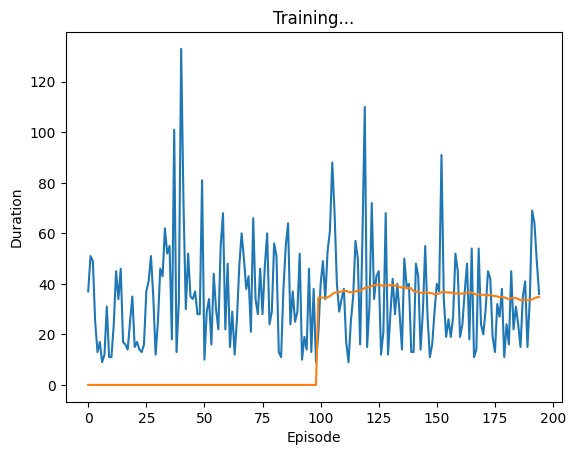

<Figure size 640x480 with 0 Axes>

In [ ]:

# creating the cart pole environment in a way that allows us to render the observation as an image
env = gym.make("CartPole-v1", render_mode='rgb_array')

### You can obtain an image of the current state of the system as follows:
###     current_img_state = env.render()

# YOUR CODE HERE
def rgb_to_grayscale(rgb_array):
    # Convert RGB to grayscale using the luminance formula
    grayscale = 0.2989 * rgb_array[:, :, 0] + 0.5870 * rgb_array[:, :, 1] + 0.1140 * rgb_array[:, :, 2]
    return grayscale
def crop_center(image, crop_height, crop_width):
    # Get the center coordinates of the image
    center_y, center_x = image.shape[0] // 2, image.shape[1] // 2
    # Calculate cropping coordinates
    start_y = max(center_y - crop_height // 2, 0)
    start_x = max(center_x - crop_width // 2, 0)
    end_y = start_y + crop_height
    end_x = start_x + crop_width
    # Crop the image
    return image[start_y:end_y, start_x:end_x]

observation, info = env.reset()
current_img_state = env.render()

obs_shape = current_img_state.shape
action_shape = env.action_space.n

agent = LearningAgent((35,70), action_shape)

if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes = 500
episode_durations = []
steps_done = 0
for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    _, info = env.reset()
    img = env.render()
    img = Image.fromarray(img, mode='RGB') 
    # img =  torch.tensor(state, dtype=torch.float32, device=agent.device).unsqueeze(0)
    transform = transforms.Compose([transforms.Grayscale(num_output_channels=1), 
                                    transforms.Resize((70, 70)),
                                    transforms.Lambda(lambda img: img.crop((0, 25, img.width, 60))),
                                    transforms.ToTensor()])
    state = transform(img).squeeze(0).numpy()
#     state = rgb_to_grayscale(img)
#     state = crop_center(state, 200, 200)
#     state = cv2.resize(state, (50, 50), interpolation=cv2.INTER_AREA)
    state = torch.tensor(state, dtype=torch.float32, device=agent.device).unsqueeze(0).unsqueeze(0)
    for t in count():
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * \
            math.exp(-1. * steps_done / EPS_DECAY)
        steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                # t.max(1) will return the largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                action = agent.sample_action(state)
        else:
            action = torch.tensor([[env.action_space.sample()]], device=agent.device, dtype=torch.long)
        _, reward, terminated, truncated, _ = env.step(action.item())
        observation = env.render()
        reward = torch.tensor([reward], device=agent.device)
        done = terminated or truncated
        
        if terminated:
            next_state = None
        else:
#             observation = rgb_to_grayscale(observation)
#             observation = crop_center(observation, 200, 200)
#             observation = cv2.resize(observation, (50, 50), interpolation=cv2.INTER_AREA)
            observation = Image.fromarray(observation, mode='RGB') 
            transform = transforms.Compose([transforms.Grayscale(num_output_channels=1), 
                                            transforms.Resize((70, 70)),
                                            transforms.Lambda(lambda img: img.crop((0, 25, img.width, 60))),
                                           transforms.ToTensor()])
            observation = transform(observation).squeeze(0).numpy()
            
            next_state = torch.tensor(observation, dtype=torch.float32, device=agent.device).unsqueeze(0).unsqueeze(0)

        # Store the transition in memory
        agent.memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        agent.optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = agent.target_net.state_dict()
        policy_net_state_dict = agent.policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        agent.target_net.load_state_dict(target_net_state_dict)
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

 
# raise NotImplementedError()

In [35]:
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

(35, 70)


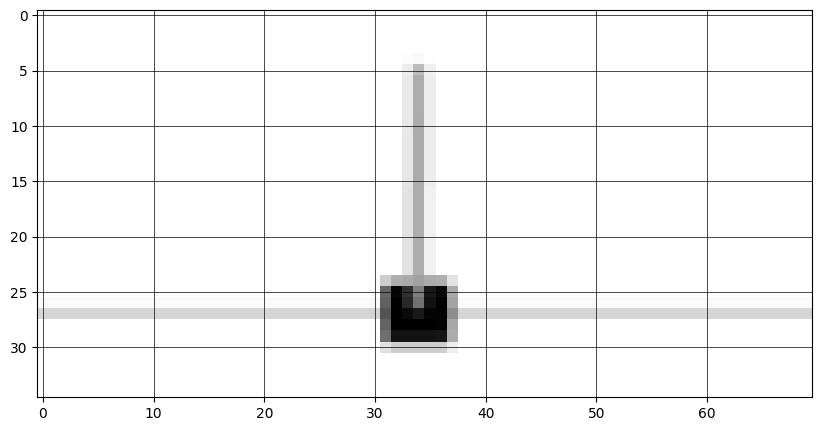

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np
from PIL import Image
env = gym.make("CartPole-v1", render_mode='rgb_array')
_, info = env.reset()
img = env.render()
img = Image.fromarray(img, mode='RGB') 
# img =  torch.tensor(state, dtype=torch.float32, device=agent.device).unsqueeze(0)
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1), 
                                transforms.Resize((70, 70)),
                                transforms.Lambda(lambda img: img.crop((0, 25, img.width, 60))), 
                                transforms.ToTensor()])
state = transform(img).squeeze(0).numpy()

print(state.shape)
plt.figure(figsize=(10, 6))
# Visualizing the image
plt.imshow(state, cmap='gray' if state.ndim == 2 else None)
plt.axis('on')  # Hide the axes
plt.grid(color='black', linestyle='-', linewidth=0.5)  # Customize grid color and style

plt.show()

Discuss the observations from your evaluation here.

YOUR ANSWER HERE

## Combining Visual and Explicit State Information [30 points]

Modify your implementation of the policy network so that it takes both the image and the explicit state information of the system as separate inputs (thus turning the policy into a multimodal policy). Then, update the learning loop accordingly and verify that learning is indeed taking place.

In [ ]:
class UpdatedLearningAgent(nn.Module):
    def __init__(self):
        # YOUR CODE HERE
        raise NotImplementedError()

    def sample_action(self):
        """Samples an action from the policy.
        """
        # YOUR CODE HERE
        raise NotImplementedError()

    def update(self):
        """Updates the network parameters.
        """
        # YOUR CODE HERE
        raise NotImplementedError()

In [ ]:
# creating the cart pole environment in a way that allows us to render the observation as an image
env = gym.make("CartPole-v1", render_mode='rgb_array')

### You can obtain an image of the current state of the system as follows:
###     current_img_state = env.render()

# YOUR CODE HERE
raise NotImplementedError()

Has the second modality changed the behaviour of the agent? Discuss the observations from your evaluation here.

YOUR ANSWER HERE